In [1]:
# Import libraries
# type: ignore
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model evaluation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Read data
def read_data(filename):
    data = pd.read_csv(f"../Data/process/{filename}_transform.csv", header=0)
    return data.drop(['churn'], axis=1), data['churn']

# Get model
def get_model(classifier):
    with open(f"../Model/{classifier}_model.pkl", 'rb+') as f:
        classifier = pickle.load(f)
        return classifier

In [3]:
# Datasets
X_train, y_train = read_data('train')          # Training data
X_valid, y_valid = read_data('Valid')          # Validation data
X_test, y_test = read_data('test')             # Test data

In [4]:
# Concate the training and validation data
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [5]:
# Get saved best classifier model
XGB_model = get_model('XGB')
KNN_model = get_model('KNN')
LR_model = get_model('LR')
RF_model = get_model('RF')

In [6]:
# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

# Model training
eclf = VotingClassifier(estimators=[('lr', LR_model), 
                                    ('rf', RF_model), 
                                    ('knn', KNN_model), 
                                    ('xgb', XGB_model)], 
                        voting='soft'
                       )
eclf = eclf.fit(X, y)

In [7]:
# Make predictions
y_test_preds = eclf.predict_proba(X_test)[:, 1]
y_preds = (y_test_preds > 0.4).astype(int)

In [8]:
# Model evalaution
roc_score = roc_auc_score(y_test, y_test_preds)
accuracy = accuracy_score(y_test, y_preds)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_preds, average='macro')

print("ROC-AUC Score:: %.3f" %roc_score)
print("Accuracy Score:: %.3f" %accuracy)
print("Precision Score:: %.3f" %precision)
print("Recall Score:: %.3f" %recall)
print("F1-score:: %.3f" %f1score)

ROC-AUC Score:: 0.856
Accuracy Score:: 0.812
Precision Score:: 0.725
Recall Score:: 0.777
F1-score:: 0.743


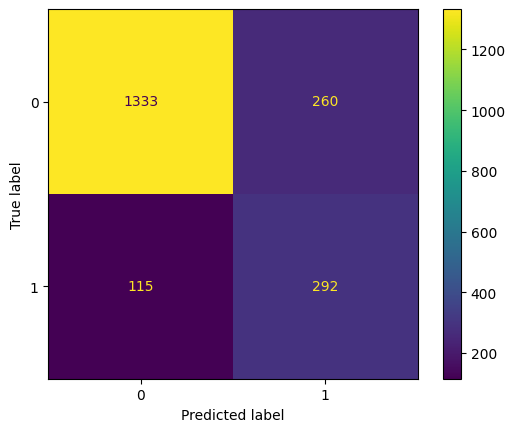

In [9]:
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(cm).plot();

- *The final model successfully classifies, 292 out of 407 customers who have churned. which indicates a recall rate of approximately 71.7%, showing the model's effectiveness in identifying churned customers.*

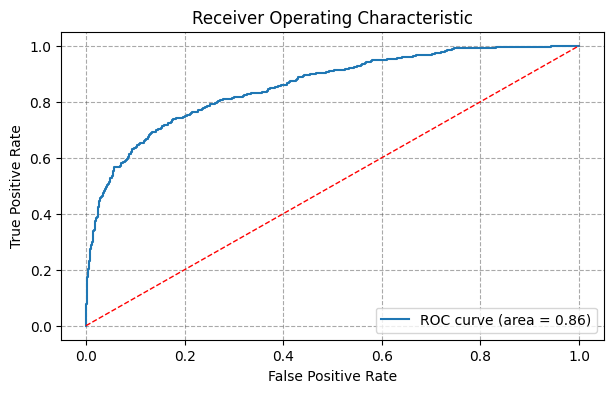

In [10]:
fpr, tpr, threshold = roc_curve(y_test, y_test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 4))

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")
plt.grid(ls='--', color='#555', alpha=0.5)
plt.show()

- *Final ensemble model shows a good overall performance with 0.86 roc-score indicates the model has good measure of separability and is able to distinguish between positive and negative classes effectively.*
- *Model has relatively high recall and f1 score.*